In [1]:
#####################
# Train & Eval
#####################

# coding=utf-8
# Copyright 2021 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lint as: python3
"""Trains TFT based on a defined set of parameters.
Uses default parameters supplied from the configs file to train a TFT model from
scratch.

Usage:
python3 script_train_fixed_params {expt_name} {output_folder}

Command line args:
  expt_name: Name of dataset/experiment to train.
  output_folder: Root folder in which experiment is saved
"""

import argparse
import datetime as dte
import os,sys
sys.path.append('/tf/crypto_prediction_ml_dl/script')
sys.path.append('/tf/crypto_prediction_ml_dl/notebook/TFT_models')

import data_formatters.base
import expt_settings.configs
import libs.hyperparam_opt
import libs.tft_custom_model
import libs.utils as utils
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf


import tensorflow
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))


ExperimentConfig = expt_settings.configs.ExperimentConfig
HyperparamOptManager = libs.hyperparam_opt.HyperparamOptManager
ModelClass = libs.tft_custom_model.TemporalFusionTransformer
tf.experimental.output_all_intermediates(True)

2023-11-25 03:44:27.371045: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-25 03:44:27.495620: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


2023-11-25 03:44:29.238083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 03:44:29.251600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 03:44:29.251750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
def main_train(expt_name,
         use_gpu,
         model_folder,
         data_csv_path,
         data_formatter,
         use_testing_mode=False):
    """Trains tft based on defined model params.

    Args:
      expt_name: Name of experiment
      use_gpu: Whether to run tensorflow with GPU operations
      model_folder: Folder path where models are serialized
      data_csv_path: Path to csv file containing data
      data_formatter: Dataset-specific data fromatter (see
        expt_settings.dataformatter.GenericDataFormatter)
      use_testing_mode: Uses a smaller models and data sizes for testing purposes
        only -- switch to False to use original default settings
    """

    num_repeats = 1

    if not isinstance(data_formatter, data_formatters.base.GenericDataFormatter):
        raise ValueError(
            "Data formatters should inherit from" +
            "AbstractDataFormatter! Type={}".format(type(data_formatter)))

    # Tensorflow setup
    default_keras_session = tf.keras.backend.get_session()

    if use_gpu:
        tf_config = utils.get_default_tensorflow_config(tf_device="gpu", gpu_id=0)

    else:
        tf_config = utils.get_default_tensorflow_config(tf_device="cpu")

    print("*** Training from defined parameters for {} ***".format(expt_name))

    print("Loading & splitting data...")
    raw_data = pd.read_csv(data_csv_path, index_col=0)
    train, valid, test = data_formatter.split_data(raw_data)
    train_samples, valid_samples = data_formatter.get_num_samples_for_calibration()

    # Sets up default params
    fixed_params = data_formatter.get_experiment_params()
    params = data_formatter.get_default_model_params()
    params["model_folder"] = model_folder

    # Parameter overrides for testing only! Small sizes used to speed up script.
    if use_testing_mode:
        fixed_params["num_epochs"] = 1
        params["hidden_layer_size"] = 5
        train_samples, valid_samples = 100, 10

    # Sets up hyperparam manager
    print("*** Loading hyperparm manager ***")
    opt_manager = HyperparamOptManager({k: [params[k]] for k in params},
                                       fixed_params, model_folder)


    # Training -- one iteration only
    print("*** Running calibration ***")
    print("Params Selected:")
    for k in params:
        print("{}: {}".format(k, params[k]))

    best_loss = np.Inf
    for _ in range(num_repeats):

        tf.reset_default_graph()
        with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:

            tf.keras.backend.set_session(sess)

            params = opt_manager.get_next_parameters()
            model = ModelClass(params, use_cudnn=use_gpu)

            if not model.training_data_cached():
                model.cache_batched_data(train, "train", num_samples=train_samples)
                model.cache_batched_data(valid, "valid", num_samples=valid_samples)

            sess.run(tf.global_variables_initializer())
            model.fit()

            val_loss = model.evaluate()

            if val_loss < best_loss:
                opt_manager.update_score(params, val_loss, model)
                best_loss = val_loss

            tf.keras.backend.set_session(default_keras_session)

    print("*** Running tests ***")
    tf.reset_default_graph()
    with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:
        tf.keras.backend.set_session(sess)
        
        best_params = opt_manager.get_best_params()
        
        model = ModelClass(best_params, use_cudnn=use_gpu)

        model.load(opt_manager.hyperparam_folder)

        print("Computing best validation loss")
        val_loss = model.evaluate(valid)

        print("Computing test loss")
        output_map = model.predict_with_custom_loss(test, return_targets=True)

        targets = output_map["targets"]
        results = output_map["results"]

        tf.keras.backend.set_session(default_keras_session)

    print("Training completed @ {}".format(dte.datetime.now()))
    print("Best validation loss = {}".format(val_loss))
    print("Params:")

    for k in best_params:
        print(k, " = ", best_params[k])
    
    return output_map

In [3]:

dataset_name = 'crypto_day'
output_folder = '.'
use_tensorflow_with_gpu = 'yes'

print("Using output folder {}".format(output_folder))

config = ExperimentConfig(dataset_name, output_folder)
formatter = config.make_data_formatter()


# Customise inputs to main() for new datasets.
output_map = main_train(
    expt_name=dataset_name,
    use_gpu=use_tensorflow_with_gpu,
    model_folder=os.path.join(config.model_folder, "fixed"),
    data_csv_path=config.data_csv_path,
    data_formatter=formatter,
    use_testing_mode=False)  # Change to false to use original default params



Using output folder .


2023-11-25 03:44:38.752581: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 03:44:38.752839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 03:44:38.753064: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Selecting GPU ID=0
*** Training from defined parameters for crypto_day ***
Loading & splitting data...
Formatting train-valid-test splits.
Setting scalers with training data...
*** Loading hyperparm manager ***
*** Running calibration ***
Params Selected:
dropout_rate: 0.5
hidden_layer_size: 10
learning_rate: 0.01
minibatch_size: 64
max_gradient_norm: 100.0
num_heads: 1
stack_size: 1
model_folder: ./saved_models/crypto_day/fixed
Resetting temp folder...
*** TemporalFusionTransformer params ***
# dropout_rate = 0.5
# hidden_layer_size = 10
# learning_rate = 0.01
# max_gradient_norm = 100.0
# minibatch_size = 64
# model_folder = ./saved_models/crypto_day/fixed
# num_heads = 1
# stack_size = 1
# total_time_steps = 31
# num_encoder_steps = 30
# num_epochs = 100
# early_stopping_patience = 10
# multiprocessing_workers = 10
# column_definition = [('btc_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('btc_dt', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('btc_row_id', <DataTypes.REAL_V

2023-11-25 03:44:39.577631: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_2/stack_1' id:12 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_2/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 0 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-25 03:44:39.579752: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_2/stack_2' id:13 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_2/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 1 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation 

2023-11-25 03:44:39.798837: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization/gamma/Assign' id:435 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization/gamma/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization/gamma, TemporalFusionTransformer/layer_normalization/gamma/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-25 03:44:39.814524: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_13/stack_1' id:477 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_13/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tenso

2023-11-25 03:44:40.289044: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/ExpandDims_1/dim' id:1333 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/ExpandDims_1/dim}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-25 03:44:40.305925: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_6/bias/Assign' id:1404 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_6/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_6/bias, TemporalFusionTransformer/time_distributed_6/bias/In

2023-11-25 03:44:41.018819: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_18/stack_2' id:2396 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_18/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-25 03:44:41.125371: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_11/beta/Assign' id:2549 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_11/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_11/beta, TemporalFusionTransfo

2023-11-25 03:44:41.944590: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/Sum_2/reduction_indices' id:3246 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/Sum_2/reduction_indices}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: -1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-25 03:44:41.984377: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/cu_dnnlstm/kernel/Assign' id:3262 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/cu_dnnlstm/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/cu_dnnlstm/kernel, TemporalFusionTransformer/cu_dnnlstm/kernel/Initializer

2023-11-25 03:44:42.947587: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_22/stack_2' id:3915 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_22/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-25 03:44:42.994402: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_21/stack' id:3908 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_21/stack}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 31, 7)]              0         []                            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 7)]              0         ['input_1[0][0]']             
 Transformer/strided_slice                                                                        
 (TensorFlowOpLayer)                                                                              
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1)]                  0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0]

2023-11-25 03:44:43.305704: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_58/bias/Assign' id:4370 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_58/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_58/bias, TemporalFusionTransformer/time_distributed_58/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-25 03:44:43.382016: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_27/stack_1' id:4551 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_27/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor

 13 (TensorFlowOpLayer)                                                                           
                                                                                                  
 activation (Activation)     (None, 10)                   0         ['dense_8[0][0]']             
                                                                                                  
 dense_12 (Dense)            (None, 1, 10)                110       ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_13[0][
                                                                    0]']                          
                                                                                                  
 dense_9 (Dense)             (None, 10)                   110       ['activation[0][0]']          
                                                                                                  
 activatio

 tf_op_layer_TemporalFusion  [(None, 31, 1)]              0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0][0]'
 6 (TensorFlowOpLayer)                                              ]                             
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 1)]              0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0][0]'
 7 (TensorFlowOpLayer)                                              ]                             
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 1)]              0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0][0]'
 8 (Tensor

                                                                    0]',                          
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_11[0][
                                                                    0]']                          
                                                                                                  
 layer_normalization_2 (Lay  (None, 10)                   20        ['add_2[0][0]']               
 erNormalization)                                                                                 
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 60)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/Reshape (Tenso                                         ansformer/concat[0][0]']      
 rFlowOpLa

 time_distributed_24 (TimeD  (None, 30, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_17[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_28 (TimeD  (None, 30, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_18[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_32 (TimeD  (None, 30, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_19[0][
          

 dropout_12 (Dropout)        (None, 30, 10)               0         ['time_distributed_33[0][0]'] 
                                                                                                  
 dense_24 (Dense)            (None, 10)                   110       ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/Sum[0][0]']         
                                                                                                  
 dense_28 (Dense)            (None, 10)                   110       ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/Sum[0][0]']         
                                                                                                  
 dropout_13 (Dropout)        (None, 1, 10)                0         ['time_distributed_39[0][0]'] 
                                                                                                  
 time_dist

                                                                     'time_distributed_31[0][0]'] 
                                                                                                  
 multiply_13 (Multiply)      (None, 30, 10)               0         ['time_distributed_34[0][0]', 
                                                                     'time_distributed_35[0][0]'] 
                                                                                                  
 dense_25 (Dense)            (None, 10)                   110       ['activation_5[0][0]']        
                                                                                                  
 dense_29 (Dense)            (None, 10)                   110       ['activation_6[0][0]']        
                                                                                                  
 time_distributed_36 (TimeD  (None, 1, 1)                 11        ['tf_op_layer_TemporalFusionTr
 istribute

 yerNormalization)                                                                                
                                                                                                  
 dense_26 (Dense)            (None, 10)                   110       ['dropout_4[0][0]']           
                                                                                                  
 dense_27 (Dense)            (None, 10)                   110       ['dropout_4[0][0]']           
                                                                                                  
 dense_30 (Dense)            (None, 10)                   110       ['dropout_5[0][0]']           
                                                                                                  
 dense_31 (Dense)            (None, 10)                   110       ['dropout_5[0][0]']           
                                                                                                  
 layer_nor

                                                                                                  
 cu_dnnlstm (CuDNNLSTM)      [(None, 30, 10),             880       ['tf_op_layer_TemporalFusionTr
                              (None, 10),                           ansformer/Sum_1[0][0]',       
                              (None, 10)]                            'layer_normalization_4[0][0]'
                                                                    , 'layer_normalization_5[0][0]
                                                                    ']                            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 10)]              0         ['multiply_17[0][0]']         
 Transformer/Sum_2 (TensorF                                                                       
 lowOpLayer)                                                                                      
          

                                                                                                  
 dropout_16 (Dropout)        (None, 31, 10)               0         ['time_distributed_50[0][0]'] 
                                                                                                  
 time_distributed_51 (TimeD  (None, 31, 10)               110       ['dropout_16[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_52 (TimeD  (None, 31, 10)               110       ['dropout_16[0][0]']          
 istributed)                                                                                      
                                                                                                  
 multiply_19 (Multiply)      (None, 31, 10)               0         ['time_distributed_51[0][0]', 
          

                                                                                                  
 dense_79 (Dense)            (None, 31, 10)               100       ['layer_normalization_16[0][0]
                                                                    ']                            
                                                                                                  
 lambda_2 (Lambda)           (None, 31, 10)               0         ['dropout_17[0][0]',          
                                                                     'dense_79[0][0]']            
                                                                                                  
 dropout_18 (Dropout)        (None, 31, 10)               0         ['lambda_2[0][0]']            
                                                                                                  
 dense_82 (Dense)            (None, 31, 10)               100       ['dropout_18[0][0]']          
          

__________________________________________________________________________________________________
None
y_true(f1_metric): (None, None, None)
y_pred(f1_metric): (None, 1, 3)
w_true(f1_metric): (None, None)
data: (None, 1)
w_pred(f1_metric): (None, 1)
y_true: (None, None, None)
y_pred: (None, 1, 3)
l: ()
diff: (None, None)
w_true: (None, None)
data: (None, 1)
w_pred: (None, 1)
threshold: (None, None)
step_function(threshold): (None, None)
wae: (None, None)
Cached data "train" updated
Cached data "valid" updated
*** Fitting TemporalFusionTransformer ***
Getting batched_data
Using cached training data
Using cached validation data
Using keras standard fit


2023-11-25 03:44:43.995685: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_19/beta/Assign' id:4500 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_19/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_19/beta, TemporalFusionTransformer/layer_normalization_19/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Train on 870 samples, validate on 107 samples


2023-11-25 03:44:45.980207: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:4831 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_61_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-25 03:44:46.322863: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/TemporalFusionTransformer/layer_normalization_10/beta/v/Assign' id:9086 op device:{requested: '', assigned: ''} def:{{{node training/Adam/TemporalFusionTransformer/layer_normalization_10/beta/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/TemporalFusionTrans

Epoch 1/100


2023-11-25 03:44:49.367782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-25 03:44:49.515070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


870/870 [==============================] - ETA: 0s - loss: 37.6385 - mae: 1.7687 - mse: 4.6757 - f1_metric: 0.3922

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-25 03:44:50.094514: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:4831 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_61_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


870/870 [==============================] - 4s 5ms/sample - loss: 37.6385 - mae: 1.7687 - mse: 4.6757 - f1_metric: 0.3922 - val_loss: 61.1572 - val_mae: 1.4451 - val_mse: 2.5434 - val_f1_metric: 7.2050e-09
Epoch 2/100
870/870 [==============================] - 0s 423us/sample - loss: 23.7316 - mae: 1.5103 - mse: 3.8021 - f1_metric: 0.3566 - val_loss: 15.7585 - val_mae: 1.1507 - val_mse: 1.9083 - val_f1_metric: 7.2890e-09
Epoch 3/100
870/870 [==============================] - 0s 419us/sample - loss: 18.2668 - mae: 1.3267 - mse: 3.1080 - f1_metric: 0.3897 - val_loss: 8.0066 - val_mae: 0.8570 - val_mse: 1.1504 - val_f1_metric: 7.5736e-09
Epoch 4/100
870/870 [==============================] - 0s 428us/sample - loss: 14.3793 - mae: 1.2776 - mse: 3.0333 - f1_metric: 0.3564 - val_loss: 4.5969 - val_mae: 0.7593 - val_mse: 0.9438 - val_f1_metric: 7.2050e-09
Epoch 5/100
870/870 [==============================] - 0s 348us/sample - loss: 12.7543 - mae: 1.2563 - mse: 2.9849 - f1_metric: 0.4135 - val

2023-11-25 03:45:02.131993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 03:45:02.132591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 03:45:02.132902: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-11-25 03:45:02.350200: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization/gamma/Assign' id:435 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization/gamma/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization/gamma, TemporalFusionTransformer/layer_normalization/gamma/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-25 03:45:02.366357: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_13/stack_1' id:477 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_13/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tenso

2023-11-25 03:45:02.874085: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/ExpandDims_1/dim' id:1333 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/ExpandDims_1/dim}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-25 03:45:02.893147: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_7/kernel/Assign' id:1428 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_7/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_7/kernel, TemporalFusionTransformer/time_distributed_7/k

2023-11-25 03:45:03.582110: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_27/bias/Assign' id:2333 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_27/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_27/bias, TemporalFusionTransformer/time_distributed_27/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-25 03:45:03.622796: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_18/stack_1' id:2395 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_18/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor

2023-11-25 03:45:04.520798: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_43/bias/Assign' id:3104 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_43/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_43/bias, TemporalFusionTransformer/time_distributed_43/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-25 03:45:04.582464: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/Sum_1/reduction_indices' id:2794 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/Sum_1/reduction_indices}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<t

2023-11-25 03:45:05.590065: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/eye/concat/axis' id:3919 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/eye/concat/axis}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-25 03:45:05.637446: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_22/stack' id:3913 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_22/stack}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, an

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 31, 7)]              0         []                            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 7)]              0         ['input_1[0][0]']             
 Transformer/strided_slice                                                                        
 (TensorFlowOpLayer)                                                                              
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1)]                  0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0]

 Transformer/concat_1/conca                                         ]                             
 t (TensorFlowOpLayer)                                                                            
                                                                                                  
 multiply_2 (Multiply)       (None, 1, 10)                0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/ExpandDims[0][0]',  
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_1/concat[0][0
                                                                    ]']                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 10)]                 0         ['multiply_2[0][0]']          
 Transform

 tf_op_layer_TemporalFusion  [(None, 31, 10, 1)]          0         ['time_distributed[0][0]']    
 Transformer/stack_1 (Tenso                                                                       
 rFlowOpLayer)                                                                                    
                                                                                                  
 multiply_3 (Multiply)       (None, 10)                   0         ['dense_18[0][0]',            
                                                                     'dense_19[0][0]']            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 10, 4)]          0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/stack_2[0][0]']     
 9 (TensorFlowOpLayer)                                                                            
          

 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 18 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 10)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 19 (TensorFlowOpLayer)                                                                           
                                                                                                  
 time_distributed_37 (TimeD  (None, 1, 10)                110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/Reshape_1[0][0]']   
                                                                                                  
 time_dist

                                                                                                  
 time_distributed_29 (TimeD  (None, 30, 10)               110       ['activation_13[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_33 (TimeD  (None, 30, 10)               110       ['activation_14[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_39 (TimeD  (None, 1, 10)                110       ['activation_15[0][0]']       
 istributed)                                                                                      
                                                                                                  
 activatio

 activation_5 (Activation)   (None, 10)                   0         ['dense_24[0][0]']            
                                                                                                  
 activation_6 (Activation)   (None, 10)                   0         ['dense_28[0][0]']            
                                                                                                  
 time_distributed_40 (TimeD  (None, 1, 1)                 11        ['dropout_13[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_41 (TimeD  (None, 1, 1)                 11        ['dropout_13[0][0]']          
 istributed)                                                                                      
                                                                                                  
 dropout_1

                                                                                                  
 dropout_5 (Dropout)         (None, 10)                   0         ['dense_29[0][0]']            
                                                                                                  
 add_13 (Add)                (None, 1, 1)                 0         ['time_distributed_36[0][0]', 
                                                                     'multiply_15[0][0]']         
                                                                                                  
 multiply_16 (Multiply)      (None, 1, 10)                0         ['time_distributed_44[0][0]', 
                                                                     'time_distributed_45[0][0]'] 
                                                                                                  
 activation_8 (Activation)   (None, 30, 6)                0         ['layer_normalization_6[0][0]'
          

                                                                    ansformer/Sum[0][0]',         
                                                                     'multiply_6[0][0]']          
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 1, 1)]            0         ['activation_16[0][0]']       
 Transformer/ExpandDims_4 (                                                                       
 TensorFlowOpLayer)                                                                               
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 10, 1)]           0         ['layer_normalization_14[0][0]
 Transformer/stack_5 (Tenso                                         ']                            
 rFlowOpLayer)                                                                                    
          

                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_3[0][0]']    
                                                                                                  
 layer_normalization_3 (Lay  (None, 10)                   20        ['add_3[0][0]']               
 erNormalization)                                                                                 
                                                                                                  
 layer_normalization_15 (La  (None, 31, 10)               20        ['add_15[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 10)]              0         ['layer_normalization_3[0][0]'
 Transform

 orFlowOpLayer)                                                                                   
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 31)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/eye/diag (Tens                                         ansformer/eye/ones[0][0]']    
 orFlowOpLayer)                                                                                   
                                                                                                  
 dense_80 (Dense)            (None, 31, 10)               100       ['layer_normalization_16[0][0]
                                                                    ']                            
                                                                                                  
 dense_81 (Dense)            (None, 31, 10)               100       ['layer_normalization_16[0][0]
          

 yerNormalization)                                                                                
                                                                                                  
 time_distributed_59 (TimeD  (None, 31, 10)               110       ['layer_normalization_18[0][0]
 istributed)                                                        ']                            
                                                                                                  
 time_distributed_60 (TimeD  (None, 31, 10)               110       ['layer_normalization_18[0][0]
 istributed)                                                        ']                            
                                                                                                  
 multiply_22 (Multiply)      (None, 31, 10)               0         ['time_distributed_59[0][0]', 
                                                                     'time_distributed_60[0][0]'] 
          

INFO:tensorflow:Restoring parameters from ./saved_models/crypto_day/fixed/TemporalFusionTransformer.ckpt


2023-11-25 03:45:06.596553: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/count_2/Assign' id:4639 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/count_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/count_2, TemporalFusionTransformer/count_2/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Done.
Computing best validation loss


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-25 03:45:06.923604: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:4831 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_61_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Computing test loss


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-11-25 03:45:07.414502: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_61/Reshape_1' id:4607 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_61/Reshape_1}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](TemporalFusionTransformer/time_distributed_61/dense_91/BiasAdd, TemporalFusionTransformer/time_distributed_61/Reshape_1/shape)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training completed @ 2023-11-25 03:45:07.764487
Best validation loss = 2.250965011454074
Params:
dropout_rate  =  0.5
hidden_layer_size  =  10
learning_rate  =  0.01
max_gradient_norm  =  100.0
minibatch_size  =  64
model_folder  =  ./saved_models/crypto_day/fixed
num_heads  =  1
stack_size  =  1
total_time_steps  =  31
num_encoder_steps  =  30
num_epochs  =  100
early_stopping_patience  =  10
multiprocessing_workers  =  10
column_definition  =  [('btc_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('btc_dt', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('btc_row_id', <DataTypes.REAL_VALUED: 0>, <InputTypes.STATIC_INPUT: 3>), ('btc_low', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_high', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_open', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('btc_close', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_volume', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INP

In [7]:
output_map

{'results': array([[[ 1.1870606 , -0.49885127,  0.22607748]],
 
        [[ 1.1803877 , -0.50537467,  0.22487642]],
 
        [[ 1.1431351 , -0.5444757 ,  0.21701564]],
 
        [[ 1.1433058 , -0.5439163 ,  0.21728347]],
 
        [[ 1.142269  , -0.5447191 ,  0.21728285]],
 
        [[ 1.1196916 , -0.5677415 ,  0.21281515]],
 
        [[ 1.1228642 , -0.5638744 ,  0.2136998 ]],
 
        [[ 1.116419  , -0.5699441 ,  0.21259816]],
 
        [[ 1.1265706 , -0.5586696 ,  0.21486387]],
 
        [[ 1.170188  , -0.5119513 ,  0.22413011]],
 
        [[ 1.1607538 , -0.5201512 ,  0.22267896]],
 
        [[ 1.1641164 , -0.515931  ,  0.22349428]],
 
        [[ 1.2308323 , -0.44242954,  0.23793383]],
 
        [[ 1.1978754 , -0.47733614,  0.23083042]],
 
        [[ 1.1916902 , -0.48304573,  0.22962993]],
 
        [[ 1.215109  , -0.45675838,  0.23486894]],
 
        [[ 1.1904843 , -0.48324618,  0.22962046]],
 
        [[ 1.224493  , -0.4458538 ,  0.23701268]],
 
        [[ 1.2258401 , -0.4439547 ,

In [4]:
results = output_map["results"][:, :, 1]
results = results.reshape((results.shape[0]))
test_df = pd.DataFrame(results, columns=['pred'])

targets = output_map["targets"]
targets = targets.reshape((targets.shape[0]))
test_df['real'] = pd.DataFrame(targets)
test_df

,pred,real
0,-0.549600,-0.594439
1,-0.557087,-0.594136
2,-0.599907,-0.594912
3,-0.599697,-0.617858
4,-0.601551,-0.613765
...,...,...
57,0.331394,0.123642
58,0.198240,0.119822
59,0.234344,0.174074
60,0.230464,0.172272


<Axes: >

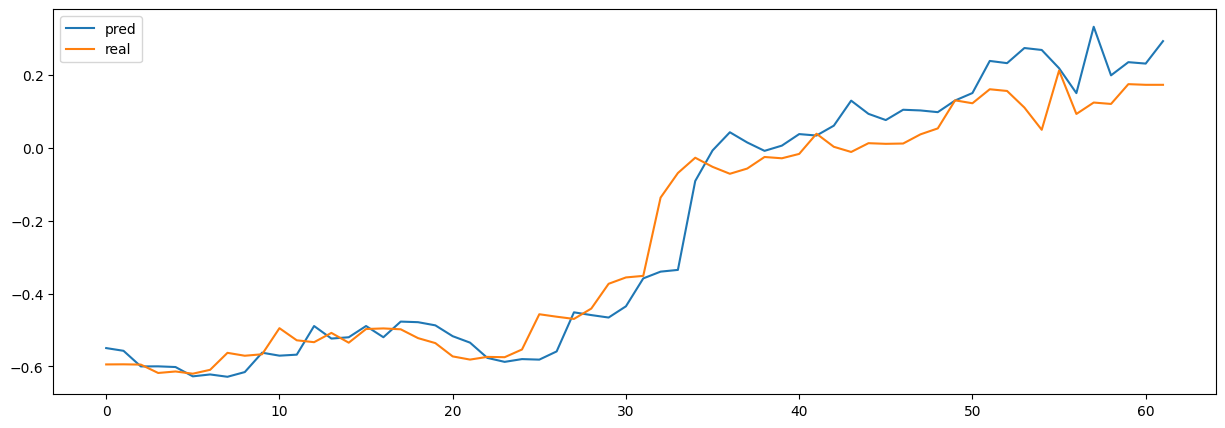

In [5]:
test_df.plot(figsize=(15,5))